In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from arch import arch_model

import warnings
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")

# === Load and preprocess data ===
df = pd.read_csv("20250503_changes_bps.csv")

# # Filter from Jan 2015
# df = df[df['date'] >= '2015-01-01']

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.set_index('date')
if df.index.freq is None:
    df.index = pd.date_range(start=df.index[0], periods=len(df.index), freq='B')

# === Define VAR columns and align for time zone differences ===
cols = ['vix_index', 'indonesia', 'malaysia', 'philippines', 'thailand']
response_countries = [c for c in cols if c != 'vix_index']
df_var = df[cols].copy()
df_var[response_countries] = df_var[response_countries].shift(-1)
df_var.dropna(inplace=True)

# === Fit VAR model ===
model = VAR(df_var)
results = model.fit(maxlags=20, ic='aic')
optimal_lag = results.k_ar
print(f"Optimal VAR lag selected by AIC: {optimal_lag}")

# === Granger Causality Tests ===
print("\nGranger Causality Results (H0: VIX index does NOT Granger-cause each country):")
results_dict = {}

for country in response_countries:
    df_pair = df_var[[country, 'vix_index']]  # Response variable first, then 'us' shock
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        test_result = grangercausalitytests(df_pair, maxlag=optimal_lag, verbose=False)

    results_dict[country] = {
        f"Lag {lag}": round(test_result[lag][0]['ssr_chi2test'][1], 4)
        for lag in range(1, optimal_lag + 1)
    }

# Convert to summary table
granger_df = pd.DataFrame(results_dict).T
print(granger_df)

Optimal VAR lag selected by AIC: 15

Granger Causality Results (H0: VIX index does NOT Granger-cause each country):
              Lag 1   Lag 2   Lag 3   Lag 4   Lag 5   Lag 6   Lag 7   Lag 8  \
indonesia    0.0278  0.0766  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
malaysia     0.1304  0.1576  0.0638  0.0661  0.0433  0.0641  0.1016  0.1004   
philippines  0.8413  0.0277  0.0831  0.1315  0.0280  0.0152  0.0269  0.0349   
thailand     0.0730  0.1988  0.3359  0.4895  0.0928  0.1116  0.0652  0.0065   

              Lag 9  Lag 10  Lag 11  Lag 12  Lag 13  Lag 14  Lag 15  
indonesia    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
malaysia     0.0487  0.0272  0.0338  0.0455  0.0638  0.0830  0.0400  
philippines  0.0105  0.0002  0.0002  0.0003  0.0005  0.0003  0.0000  
thailand     0.0082  0.0092  0.0075  0.0117  0.0172  0.0163  0.0249  


In [2]:
# === IRF cumulative and significance ===
irf = results.irf(optimal_lag)
shock_idx = results.names.index('vix_index')
response_indices = [results.names.index(c) for c in response_countries]
cumulative_irf_vals = irf.cum_effects[-1, response_indices, shock_idx]
irf_strength = dict(zip(response_countries, cumulative_irf_vals))

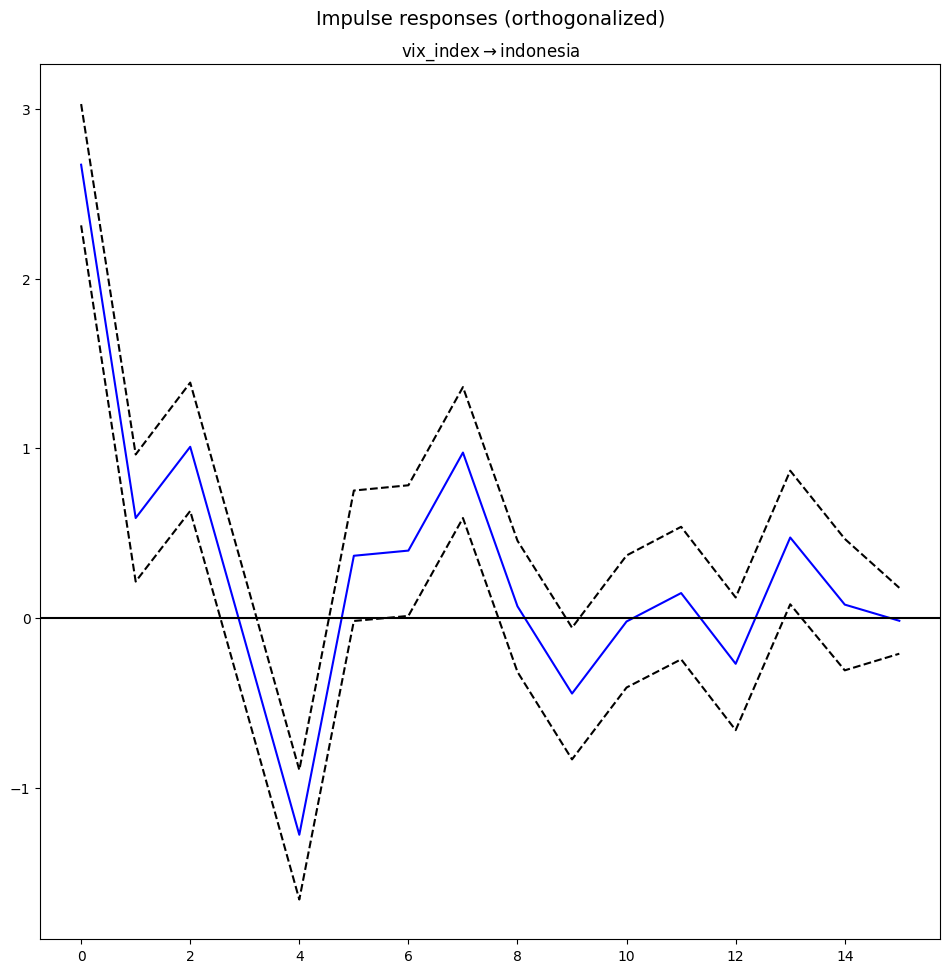

<Figure size 1400x600 with 0 Axes>

In [3]:
# Plot individual IRF with CI
irf.plot(orth=True, impulse='vix_index', response='indonesia')
plt.figure(figsize=(14, 6))
plt.suptitle("IRF: VIX Shock → Indonesia Yield", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# # Plot individual IRF with CI
# irf.plot(orth=True, impulse='vix_index', response='malaysia')
# plt.suptitle("IRF: VIX Shock → Malaysia Yield", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.show()

# # Plot individual IRF with CI
# irf.plot(orth=True, impulse='vix_index', response='philippines')
# plt.suptitle("IRF: VIX Shock → Philippines Yield", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.show()

# # Plot individual IRF with CI
# irf.plot(orth=True, impulse='vix_index', response='thailand')
# plt.suptitle("IRF: VIX Shock → Thailand Yield", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.show()

In [18]:
import pandas as pd
import numpy as np

# === Prepare Cumulative Orthogonalized IRF Table ===
# irf = results.irf(optimal_lag)
# shock_idx = results.names.index('vix_index')
# response_indices = [results.names.index(c) for c in response_countries]

# Create DataFrame to store cumulative IRF values
orth_irf_cum_table = pd.DataFrame(index=response_countries, columns=[f"Lag {i}" for i in range(1, optimal_lag+1)])
significance_table = pd.DataFrame(index=response_countries, columns=[f"Lag {i}" for i in range(1, optimal_lag+1)])

# Loop through each country and lag to compute cumulative effect + p-value marking
for country in response_countries:
    response_idx = results.names.index(country)
    cum_effect = 0
    for lag in range(1, optimal_lag+1):
        # IRF orthogonalized value at this lag
        irf_val = irf.orth_irfs[lag-1][response_idx, shock_idx]
        cum_effect += irf_val

        # p-value from original VAR coefficients
        param_label = f"L{lag}.vix_index"
        pval = results.pvalues.loc[param_label, country]

        # Significance stars
        if pval < 0.01:
            stars = "***"
        elif pval < 0.05:
            stars = "**"
        elif pval < 0.1:
            stars = "*"
        else:
            stars = ""

        # Fill tables
        orth_irf_cum_table.loc[country, f"Lag {lag}"] = round(cum_effect, 3)
        significance_table.loc[country, f"Lag {lag}"] = stars

# Combine both into one annotated table
irf_annotated = orth_irf_cum_table.copy()
for row in irf_annotated.index:
    for col in irf_annotated.columns:
        val = orth_irf_cum_table.loc[row, col]
        sig = significance_table.loc[row, col]
        irf_annotated.loc[row, col] = f"{val}{sig}"

# Optional: Add cumulative total at the end
irf_annotated["Cumulative IRF"] = orth_irf_cum_table[f"Lag {optimal_lag}"]

# Display the result
print("\n=== Cumulative Orthogonalized IRF with Significance ===")
print(irf_annotated)



=== Cumulative Orthogonalized IRF with Significance ===
               Lag 1    Lag 2     Lag 3     Lag 4    Lag 5    Lag 6     Lag 7  \
indonesia      2.671  3.26***  4.268***  4.137***  2.86***    3.227   3.624**   
malaysia     0.101**  0.023**   0.111**    0.017*    0.115    0.127     0.095   
philippines    1.146    1.274     1.292    1.457*    1.909   1.997*     1.852   
thailand       0.081    0.044     0.001     0.035   0.194*  0.178**  0.036***   

                Lag 8     Lag 9   Lag 10   Lag 11    Lag 12   Lag 13 Lag 14  \
indonesia    4.598***     4.667    4.222    4.201  4.348***  4.078**  4.553   
malaysia      0.153**  0.038***  0.149**    0.063     0.094    0.035  0.025   
philippines     2.117     2.511    3.019  3.017**     2.941    2.746  2.998   
thailand     0.216***    0.052*    0.121   -0.002    -0.009    0.038  0.121   

              Lag 15 Cumulative IRF  
indonesia      4.631          4.631  
malaysia       0.136          0.136  
philippines  3.443**       


Estimated standard deviation of structural VIX shock (from VAR residuals): 1.9333 VIX points


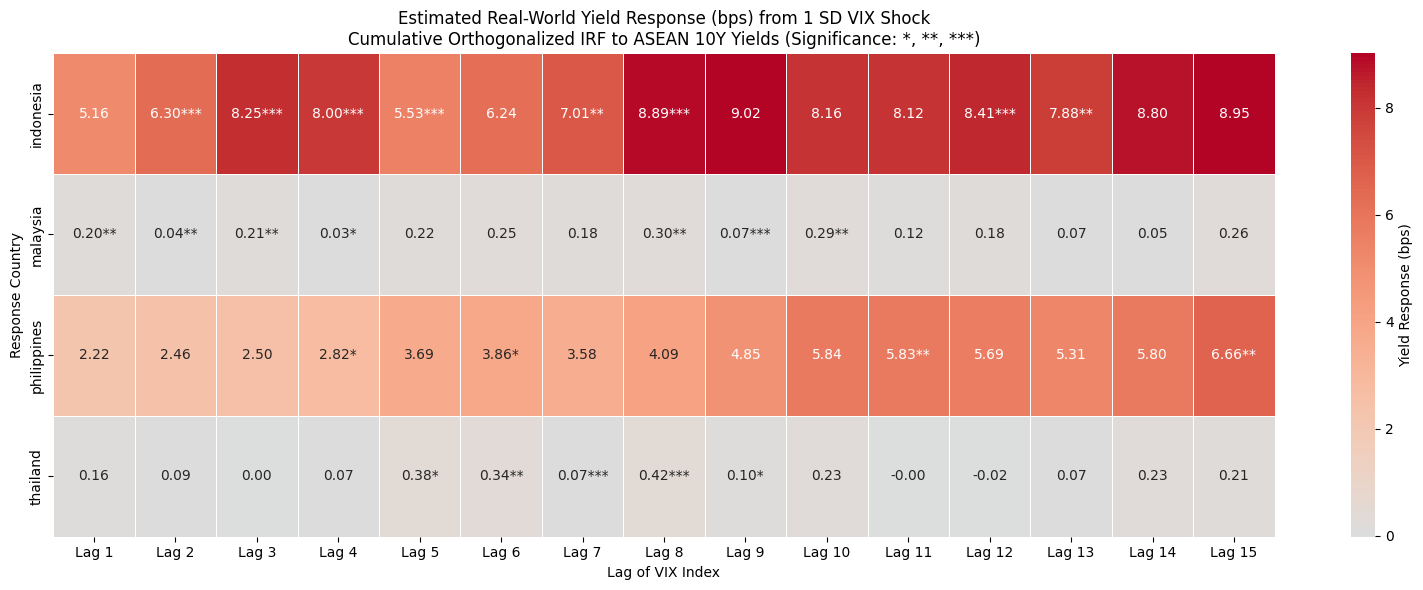

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Estimate the size of a structural VIX shock (in VIX index points) ===
# This will be used to scale IRFs into real-world yield effects
vix_shock_std = results.resid['vix_index'].std()
print(f"\nEstimated standard deviation of structural VIX shock (from VAR residuals): {vix_shock_std:.4f} VIX points")

# === Compute scaled IRF table: real-world yield response in bps ===
scaled_irf_table = orth_irf_cum_table.astype(float) * vix_shock_std

# === Format labels: scaled value with significance stars ===
scaled_annot_table = orth_irf_cum_table.copy()
for row in scaled_annot_table.index:
    for col in scaled_annot_table.columns:
        scaled_val = float(orth_irf_cum_table.loc[row, col]) * vix_shock_std
        sig = significance_table.loc[row, col]
        scaled_annot_table.loc[row, col] = f"{scaled_val:.2f}{sig}"  # show 2 decimals for bps

# === Plot Heatmap ===
plt.figure(figsize=(16, 6))
sns.heatmap(scaled_irf_table, annot=scaled_annot_table, fmt='',
            cmap="coolwarm", center=0, linewidths=0.5, cbar_kws={"label": "Yield Response (bps)"},
            linecolor='white', annot_kws={"fontsize": 10})

plt.title("Estimated Real-World Yield Response (bps) from 1 SD VIX Shock\nCumulative Orthogonalized IRF to ASEAN 10Y Yields (Significance: *, **, ***)")
plt.xlabel("Lag of VIX Index")
plt.ylabel("Response Country")
plt.tight_layout()
plt.show()


In [25]:
# === Use the correct standard deviation from VAR residuals ===
vix_shock_std = results.resid['vix_index'].std()  # structural shock size from VAR

# === Get Indonesia’s IRF responses to 1 structural VIX shock ===
shock_idx = results.names.index('vix_index')
indonesia_idx = results.names.index('indonesia')

# Get raw orthogonalized IRF responses
irf_lag_values = [irf.orth_irfs[lag][indonesia_idx, shock_idx] for lag in range(optimal_lag)]

# === Scale by the real-world size of the shock (in VIX index units) ===
scaled_irf = [val * vix_shock_std for val in irf_lag_values]

# === Simulate day-by-day cumulative impact (bps) ===
cumulative_effects = np.cumsum(scaled_irf)
lags = np.arange(1, len(irf_lag_values) + 1)

# # Optional: Plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 4))
# plt.plot(lags, cumulative_effects, marker='o', color='blue', label="Cumulative Effect")
# plt.axhline(0, color='black', linewidth=0.7)
# plt.title("Simulated Cumulative Impact on Indonesia 10Y Yield\n(Scaled to 1 SD Structural VIX Shock)")
# plt.xlabel("Days After VIX Shock")
# plt.ylabel("Yield Change (bps)")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.ylim(4, 12)
# plt.legend()
# plt.show()

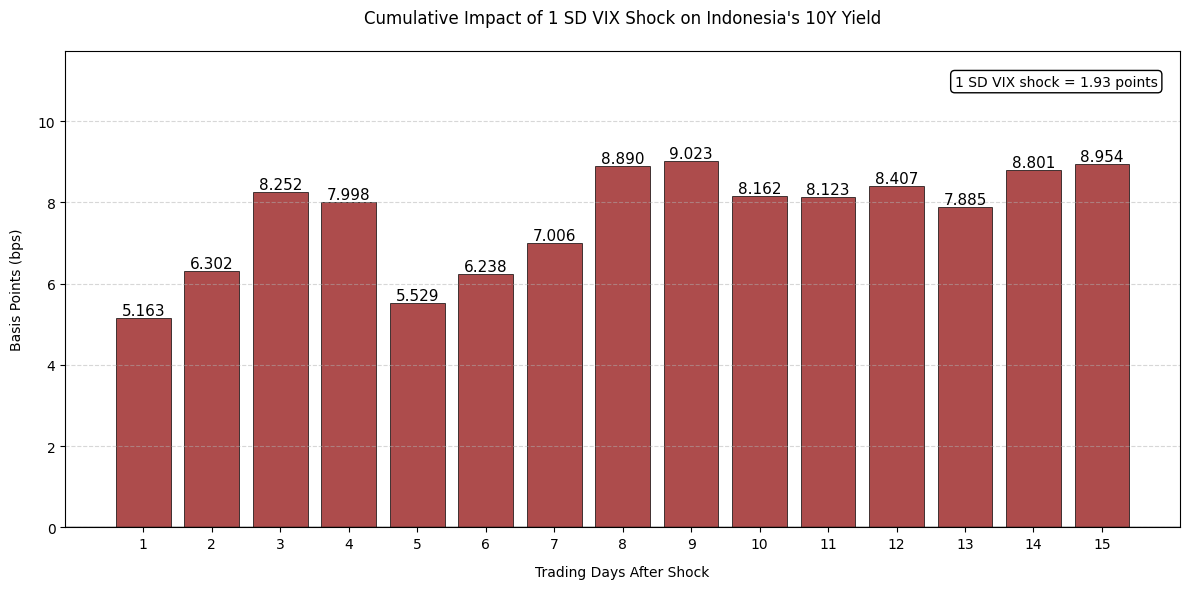

In [26]:
# === Plot as Bar Chart ===
plt.figure(figsize=(12, 6))
bars = plt.bar(lags, cumulative_effects, 
               color='darkred', 
               alpha=0.7,
               edgecolor='black',
               linewidth=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom',
             fontsize=11)

plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.title("Cumulative Impact of 1 SD VIX Shock on Indonesia's 10Y Yield", pad=20)
plt.xlabel("Trading Days After Shock", labelpad=10)
plt.ylabel("Basis Points (bps)", labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(lags)  # Ensure all lags are shown
plt.ylim(0, max(cumulative_effects)*1.3)  # Auto-scale upper limit

# Add annotation about shock size
plt.annotate(f'1 SD VIX shock = {vix_shock_std:.2f} points',
             xy=(0.98, 0.95), xycoords='axes fraction',
             ha='right', va='top',
             bbox=dict(boxstyle='round', fc='white'))

plt.tight_layout()
plt.show()

In [27]:
# === FEVD Table ===
fevd = results.fevd(optimal_lag)
fevd_data = {}
for country in response_countries:
    i = results.names.index(country)
    fevd_data[country] = fevd.decomp[:, i, shock_idx] * 100

n_horizon = fevd.decomp.shape[0]
fevd_df = pd.DataFrame(fevd_data, index=[f"h={i+1}" for i in range(n_horizon)])
print("\nForecast Error Variance Decomposition (FEVD)\nShare of VIX Index Shock in Local Variance (%):")
print("=" * 75)
print(fevd_df.round(2))


Forecast Error Variance Decomposition (FEVD)
Share of VIX Index Shock in Local Variance (%):
     indonesia  malaysia  philippines  thailand
h=1      98.87     98.71        98.75     98.73
h=2       5.06      5.62         5.62      6.56
h=3       0.10      0.15         0.20      0.26
h=4       0.74      0.74         0.75      0.86
h=5       0.03      0.04         0.04      0.14



=== GARCH(1,1) Results Summary ===
                omega   alpha    beta  pval_omega  pval_alpha  pval_beta
indonesia    148.0793  0.1838  0.8162      0.0083      0.0000        0.0
malaysia      10.4294  0.0429  0.9571      0.5402      0.0134        0.0
philippines  620.1922  0.2197  0.7803      0.0107      0.0003        0.0
thailand     147.7674  0.2930  0.7070      0.2269      0.0324        0.0

GARCH(1,1) Results Summary
              alpha    beta  Vol_Persistence
indonesia    0.1838  0.8162              1.0
malaysia     0.0429  0.9571              1.0
philippines  0.2197  0.7803              1.0
thailand     0.2930  0.7070              1.0


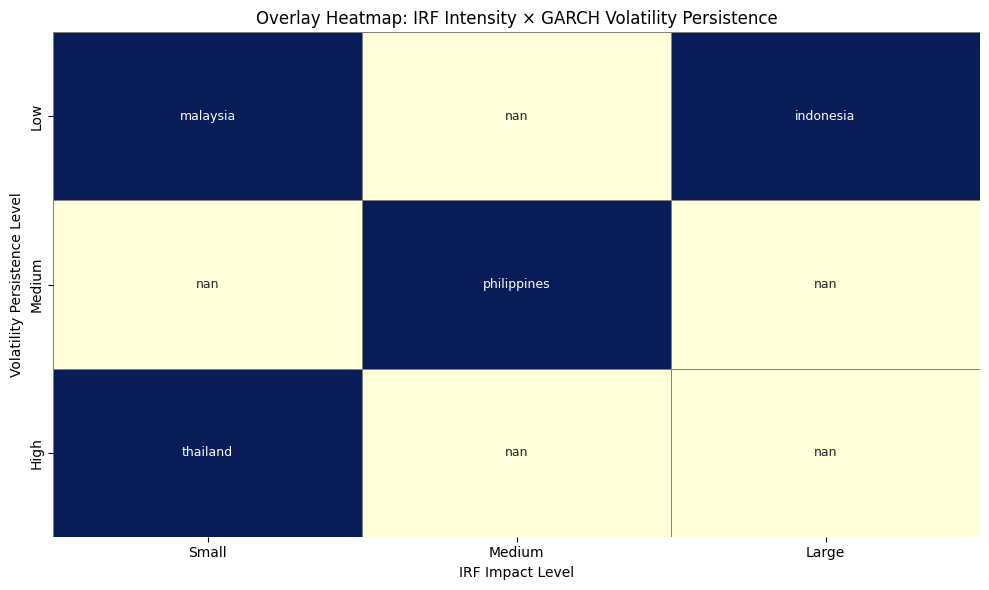


Country Cluster Labels Based on IRF-GARCH Patterns:
             Vol_Persistence  IRF_Strength    Cluster
indonesia                1.0      0.935900  Sensitive
malaysia                 1.0     -0.082753  Resilient
philippines              1.0      0.922632  Sensitive
thailand                 1.0     -0.020161  Sensitive


In [28]:
# === GARCH(1,1) ===
garch_results = {}
for country in response_countries:
    series = df_var[country] * 10
    garch = arch_model(series, vol='Garch', p=1, q=1, rescale=False)
    res = garch.fit(disp="off")
    garch_results[country] = {
        'omega': res.params.get('omega', np.nan),
        'alpha': res.params.get('alpha[1]', np.nan),
        'beta': res.params.get('beta[1]', np.nan),
        'pval_omega': res.pvalues.get('omega', np.nan),
        'pval_alpha': res.pvalues.get('alpha[1]', np.nan),
        'pval_beta': res.pvalues.get('beta[1]', np.nan),
    }

garch_df = pd.DataFrame(garch_results).T
print("\n=== GARCH(1,1) Results Summary ===")
print(garch_df.round(4))

garch_df['Vol_Persistence'] = garch_df['alpha'] + garch_df['beta']
garch_df['IRF_Strength'] = garch_df.index.map(irf_strength)

# === Show GARCH Table ===
print("\nGARCH(1,1) Results Summary")
print("=" * 75)
print(garch_df[['alpha', 'beta', 'Vol_Persistence']].round(4))

# === Overlay IRF × GARCH Heatmap ===
garch_df['Vol_Category'] = pd.qcut(garch_df['Vol_Persistence'], 3, labels=["Low", "Medium", "High"])
garch_df['IRF_Category'] = pd.qcut(garch_df['IRF_Strength'], 3, labels=["Small", "Medium", "Large"])
garch_df['Country'] = garch_df.index

pivot_table = (
    garch_df.groupby(['Vol_Category', 'IRF_Category'], observed=False)['Country']
    .apply(lambda x: '\n'.join(x))
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table.notna(),
            annot=pivot_table, fmt='', cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor='gray', annot_kws={"fontsize": 9})
plt.title("Overlay Heatmap: IRF Intensity × GARCH Volatility Persistence")
plt.xlabel("IRF Impact Level")
plt.ylabel("Volatility Persistence Level")
plt.tight_layout()
plt.show()

# === Add Labels Based on Patterns ===
def classify(row):
    if row['Vol_Category'] == "High" and row['IRF_Category'] == "Large":
        return "Fragile"
    elif row['Vol_Category'] == "Low" and row['IRF_Category'] == "Small":
        return "Resilient"
    else:
        return "Sensitive"

garch_df['Cluster'] = garch_df.apply(classify, axis=1)
print("\nCountry Cluster Labels Based on IRF-GARCH Patterns:")
print("=" * 75)
print(garch_df[['Vol_Persistence', 'IRF_Strength', 'Cluster']])